In [26]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import (
    StructType, StructField, StringType,
    IntegerType, DoubleType, TimestampType
)
import os
import matplotlib.pyplot as plt
base_path = "abfss://f4041c98-2c4f-44a4-82ec-ab26f8d5d0b3@onelake.dfs.fabric.microsoft.com/d3c25d34-1652-45f9-b4f3-58b4aedb4efa/Files/bronze/"
spark = SparkSession.builder.appName("OrderItemsSilverPipeline").getOrCreate()

StatementMeta(, d2e8dd10-4239-4b99-8e3f-f174cc906ef0, 28, Finished, Available, Finished)

In [27]:
# order_items_schema = StructType([
#     StructField("order_id", StringType(), False),
#     StructField("order_item_id", IntegerType(), False),
#     StructField("product_id", StringType(), False),
#     StructField("seller_id", StringType(), False),
#     StructField("shipping_limit_date", TimestampType(), True),
#     StructField("price", DoubleType(), True),
#     StructField("freight_value", DoubleType(), True),
# ])

StatementMeta(, d2e8dd10-4239-4b99-8e3f-f174cc906ef0, 29, Finished, Available, Finished)

In [28]:
# order_items_path = os.path.join(base_path, "olist_order_items_dataset.csv")

# order_items_df = spark.read.csv(
#     order_items_path,
#     header=True,
#     schema=order_items_schema
# ).repartition(20)

order_items_df = spark.read.table("br_order_items")

print("Order Items schema:")
order_items_df.printSchema()
order_items_df.show(5, truncate=False)

StatementMeta(, d2e8dd10-4239-4b99-8e3f-f174cc906ef0, 30, Finished, Available, Finished)

Order Items schema:
root
 |-- order_id: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)

+--------------------------------+-------------+--------------------------------+--------------------------------+-------------------+-----+-------------+
|order_id                        |order_item_id|product_id                      |seller_id                       |shipping_limit_date|price|freight_value|
+--------------------------------+-------------+--------------------------------+--------------------------------+-------------------+-----+-------------+
|00010242fe8c5a6d1ba2dd792cb16214|1            |4244733e06e7ecb4970a6e2683c13e61|48436dade18ac8b2bce089ec2a041202|2017-09-19 09:45:35|58.9 |13.29        |
|00018f77f2f0320c557190d7a144bdd3|1            |e

In [29]:
# added to compare row counts before cleaning
order_items_df.count()

StatementMeta(, d2e8dd10-4239-4b99-8e3f-f174cc906ef0, 31, Finished, Available, Finished)

112650

In [30]:
quarantine_df = order_items_df.filter(
    (F.col("order_id").isNull()) |
    (F.col("order_item_id").isNull()) |
    (F.col("product_id").isNull()) |
    (F.col("seller_id").isNull()) |
    (F.col("price").isNull() | (F.col("price") < 0)) |
    (F.col("freight_value").isNull() | (F.col("freight_value") < 0)) |
    (F.col("shipping_limit_date").isNull())
)

clean_order_items_df = order_items_df.subtract(quarantine_df)

print("Quarantined rows:", quarantine_df.count())
print("Clean rows:", clean_order_items_df.count())

StatementMeta(, d2e8dd10-4239-4b99-8e3f-f174cc906ef0, 32, Finished, Available, Finished)

Quarantined rows: 0
Clean rows: 112650


In [31]:
clean_order_items_df = clean_order_items_df.withColumn(
    "total_item_value",
    F.col("price") + F.col("freight_value")
)

StatementMeta(, d2e8dd10-4239-4b99-8e3f-f174cc906ef0, 33, Finished, Available, Finished)

In [32]:
# Added: Write clean + quarantine to Silver Lakehouse tables
clean_order_items_df.write.format("delta").mode("overwrite").saveAsTable("lh_silver_olist.sl_order_item")
quarantine_df.write.format("delta").mode("overwrite").save("Tables/qr_order_items")

print("✅ Silver tables saved: sl_order_items, sl_order_items_quarantine")

StatementMeta(, d2e8dd10-4239-4b99-8e3f-f174cc906ef0, 34, Finished, Available, Finished)

✅ Silver tables saved: sl_order_items, sl_order_items_quarantine


In [33]:
# silver_path = "file://" + os.path.join(base_path, "silver_olist_order_items")
# quarantine_path = "file://" + os.path.join(base_path, "quarantine_olist_order_items")

# clean_order_items_df.write.mode("overwrite").parquet(silver_path)
# quarantine_df.write.mode("overwrite").parquet(quarantine_path)

# print(f"Silver dataset saved to: {silver_path}")
# print(f"Quarantine dataset saved to: {quarantine_path}")

StatementMeta(, d2e8dd10-4239-4b99-8e3f-f174cc906ef0, 35, Finished, Available, Finished)

In [34]:
top_products = (
    clean_order_items_df.groupBy("product_id")
    .agg(F.sum("total_item_value").alias("total_sales"))
    .orderBy(F.desc("total_sales"))
    .limit(10)
)

print("Top 10 products by sales:")
top_products.show(truncate=False)

StatementMeta(, d2e8dd10-4239-4b99-8e3f-f174cc906ef0, 36, Finished, Available, Finished)

Top 10 products by sales:
+--------------------------------+------------------+
|product_id                      |total_sales       |
+--------------------------------+------------------+
|bb50f2e236e5eea0100680137654686c|67606.09999999999 |
|d1c427060a0f73f6b889a5c7c61f2ac4|60976.03          |
|6cdd53843498f92890544667809f1595|59093.99          |
|99a4788cb24856965c36a24e339b6058|51071.600000000006|
|d6160fb7873f184099d9bc95e30376af|50326.18000000001 |
|3dd2a17168ec895c781a9191c1e95ad7|48212.22000000001 |
|aca2eb7d00ea1a7b8ebd4e68314663af|44820.75999999999 |
|5f504b3a1c75b73d6151be81eb05bdc9|41725.81          |
|25c38557cf793876c5abdd5931f922db|40311.950000000004|
|53b36df67ebb7c41585e8d54d6772e08|39957.93          |
+--------------------------------+------------------+



StatementMeta(, d2e8dd10-4239-4b99-8e3f-f174cc906ef0, 37, Finished, Available, Finished)

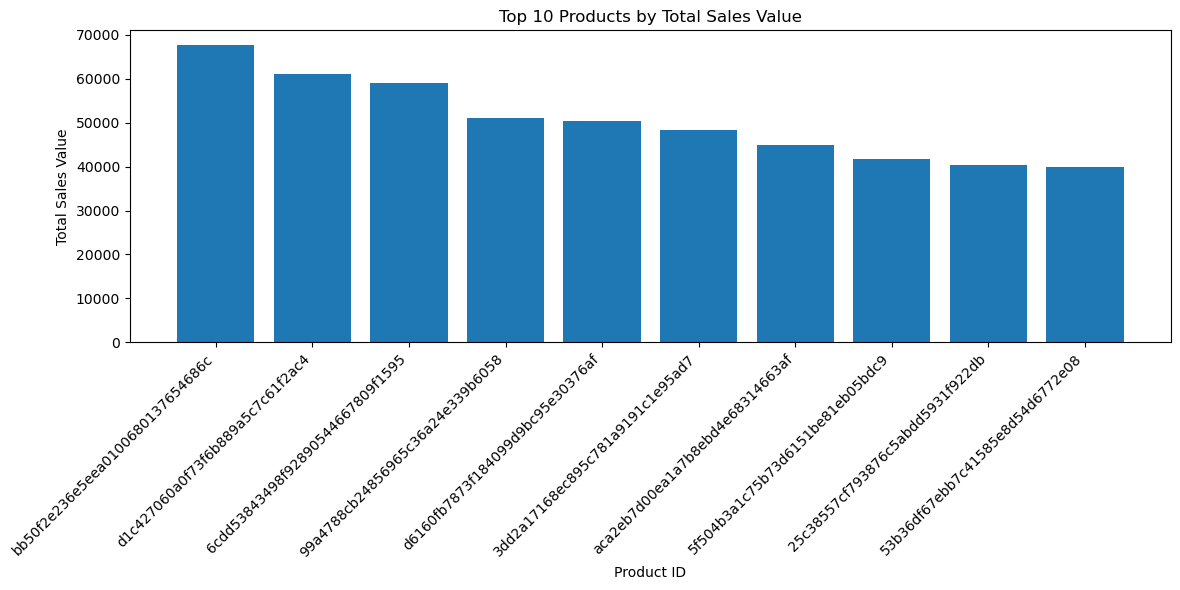

In [35]:
top_products_pd = top_products.toPandas()

plt.figure(figsize=(12,6))
plt.bar(top_products_pd["product_id"], top_products_pd["total_sales"])
plt.title("Top 10 Products by Total Sales Value")
plt.xlabel("Product ID")
plt.ylabel("Total Sales Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

StatementMeta(, d2e8dd10-4239-4b99-8e3f-f174cc906ef0, 38, Finished, Available, Finished)

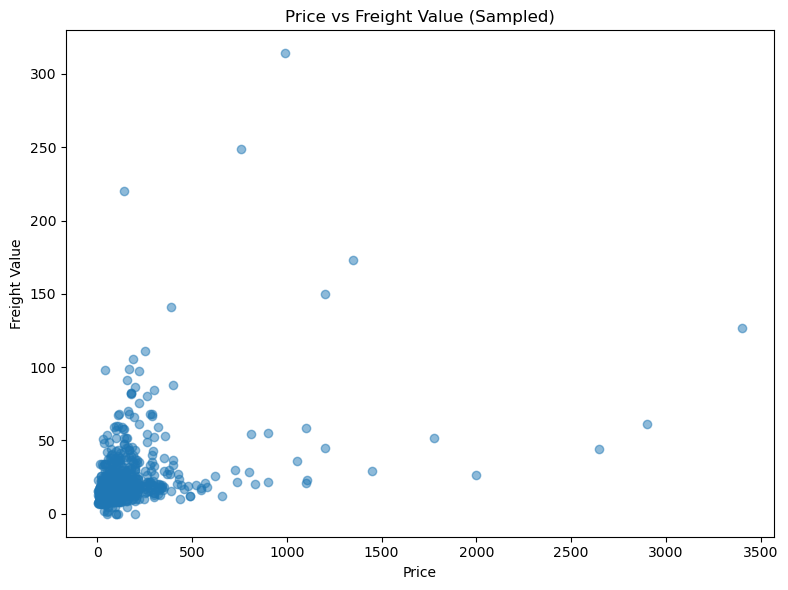

In [36]:
sample_pd = clean_order_items_df.select("price", "freight_value").sample(False, 0.01, seed=42).toPandas()

plt.figure(figsize=(8,6))
plt.scatter(sample_pd["price"], sample_pd["freight_value"], alpha=0.5)
plt.title("Price vs Freight Value (Sampled)")
plt.xlabel("Price")
plt.ylabel("Freight Value")
plt.tight_layout()
plt.show()

StatementMeta(, d2e8dd10-4239-4b99-8e3f-f174cc906ef0, 39, Finished, Available, Finished)

Top 10 products by total items sold:
+--------------------------------+----------------+
|product_id                      |total_items_sold|
+--------------------------------+----------------+
|aca2eb7d00ea1a7b8ebd4e68314663af|527             |
|99a4788cb24856965c36a24e339b6058|488             |
|422879e10f46682990de24d770e7f83d|484             |
|389d119b48cf3043d311335e499d9c6b|392             |
|368c6c730842d78016ad823897a372db|388             |
|53759a2ecddad2bb87a079a1f1519f73|373             |
|d1c427060a0f73f6b889a5c7c61f2ac4|343             |
|53b36df67ebb7c41585e8d54d6772e08|323             |
|154e7e31ebfa092203795c972e5804a6|281             |
|3dd2a17168ec895c781a9191c1e95ad7|274             |
+--------------------------------+----------------+



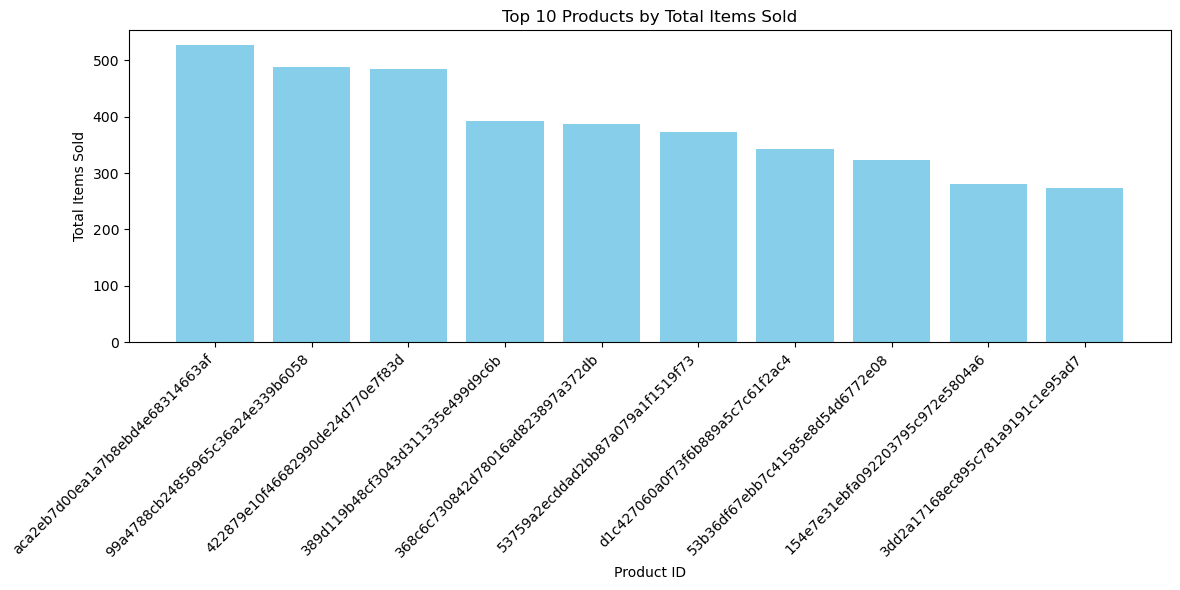

Total items sold (all products): 112650


In [37]:
items_sold = (
    clean_order_items_df.groupBy("product_id")
    .agg(F.count("order_item_id").alias("total_items_sold"))
    .orderBy(F.desc("total_items_sold"))
    .limit(10)  # top 10 products by quantity
)

print("Top 10 products by total items sold:")
items_sold.show(truncate=False)

# Convert to pandas for plotting
items_sold_pd = items_sold.toPandas()

plt.figure(figsize=(12,6))
plt.bar(items_sold_pd["product_id"], items_sold_pd["total_items_sold"], color='skyblue')
plt.title("Top 10 Products by Total Items Sold")
plt.xlabel("Product ID")
plt.ylabel("Total Items Sold")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

total_items_sold = clean_order_items_df.count()
print(f"Total items sold (all products): {total_items_sold}")
